In [3]:
import cv2
import numpy as np
import pandas as pd
import shutil
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D,Dense,Flatten,Dropout,AvgPool2D
from keras.layers import BatchNormalization
from keras.constraints import unit_norm

In [4]:
labels=pd.read_csv('../input/dog-breed-identification/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
breeds=list(labels['breed'].unique())
len(breeds)

120

In [6]:
## dividing the train data into different folders according to their breed names
os.mkdir('/kaggle/working/new_train')

for i in range(len(labels)):
    if labels['breed'][i] not in os.listdir('/kaggle/working/new_train'):
        os.mkdir('/kaggle/working/new_train/'+labels['breed'][i])
    shutil.copy('../input/dog-breed-identification/train/'+labels['id'][i]+'.jpg', '/kaggle/working/new_train/'+labels['breed'][i])


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


image_size=224  #for the inception model
image_path='/kaggle/working/new_train/'

train_datagen=ImageDataGenerator(
                        rescale=1./255,
                        validation_split=0.1,
                        horizontal_flip=True,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        rotation_range=40,
                        fill_mode='nearest'
                        )

train_generator=train_datagen.flow_from_directory(
                        image_path, 
                        target_size=(image_size,image_size),
                        subset='training',
                        shuffle=True,
                        batch_size=128,
                        class_mode='categorical'
                        )

valid_datagen=ImageDataGenerator(
                        validation_split=0.1,
                        rescale=1./255
                        )

valid_generator=valid_datagen.flow_from_directory(
                        image_path, 
                        target_size=(image_size,image_size),
                        subset='validation',
                        shuffle=False,
                        batch_size=128,
                        class_mode='categorical'
                        )

Found 9254 images belonging to 120 classes.
Found 968 images belonging to 120 classes.


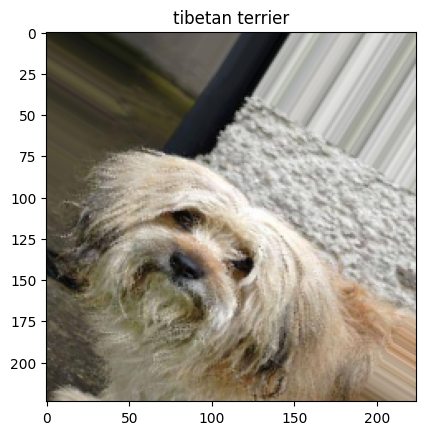

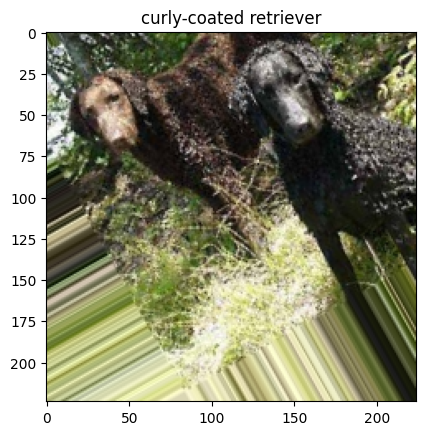

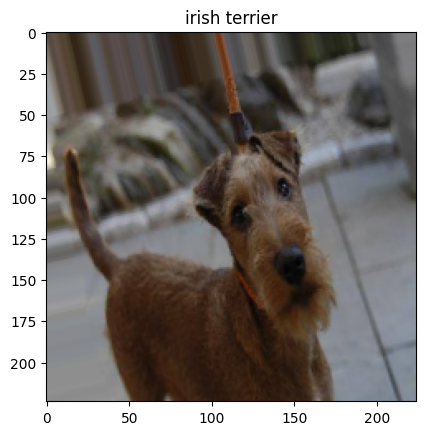

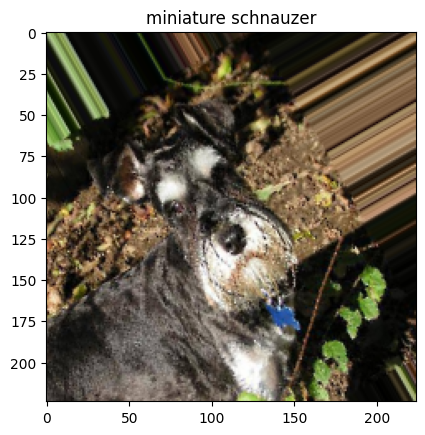

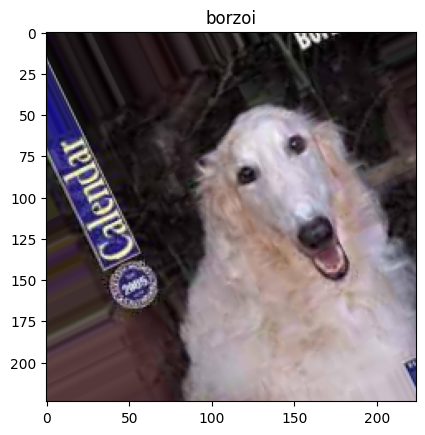

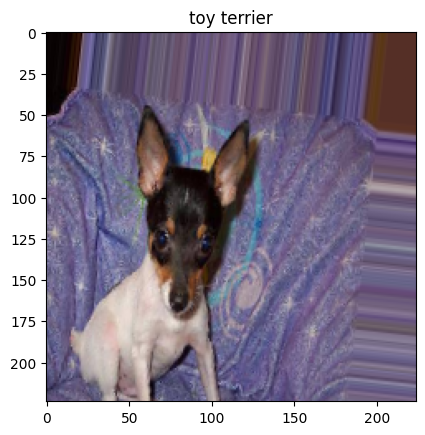

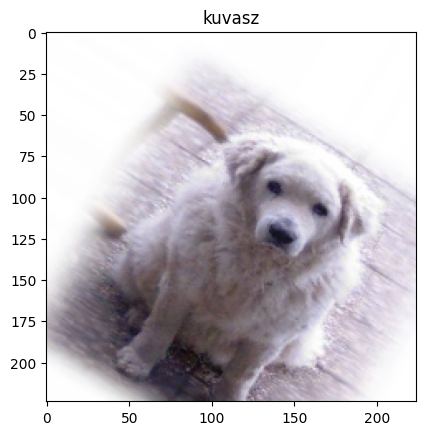

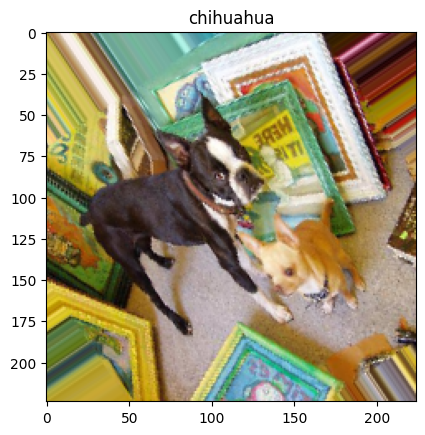

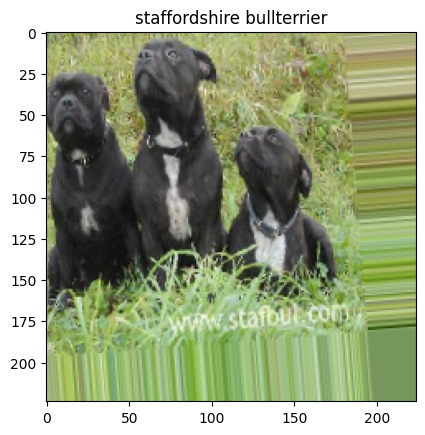

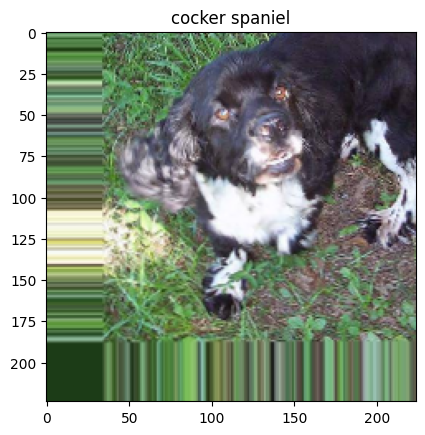

In [8]:
x,y = train_generator.next()
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
for i in range(0,10):
    image = x[i]
    plt.imshow(image)
    c=0
    for i in y[i]:
        if i==0:
            c+=1
        else:break
    label=labels[c]
    label=label.replace('_',' ')
    label=label.lower()
    plt.title(label)
    plt.show()

In [9]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming 'breeds' is a list of your target classes

# Using pre-trained weights for the Inception model
local_weights_file = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
Inception = InceptionV3(input_shape=(224, 224, 3),
                        include_top=False,
                        weights=local_weights_file)

model2 = Sequential()
model2.add(Inception)
model2.add(GlobalAveragePooling2D())
model2.add(BatchNormalization())
model2.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))  # Reduced units
model2.add(BatchNormalization())
model2.add(Dense(len(breeds), activation='softmax', kernel_regularizer=l2(0.01)))

# Unfreeze more layers of the Inception model for fine-tuning
for layer in model2.layers[0].layers[-30:]:
    layer.trainable = True

# Define a learning rate scheduler to adjust the learning rate during training
def lr_schedule(epoch):
    initial_lr = 0.0001  # Lower initial learning rate
    drop = 0.5
    epochs_drop = 15
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

# Using Adam optimizer with a lower learning rate
adam = Adam(learning_rate=0.0001)

model2.compile(optimizer=adam,
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Create an ImageDataGenerator for data augmentation with more aggressive settings
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Assuming you have a train_generator and validation_generator for your data
epochs = 100
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Example usage of LearningRateScheduler and EarlyStopping callbacks
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Example usage of LearningRateScheduler, EarlyStopping, and ModelCheckpoint callbacks
history = model2.fit(train_generator,
                    epochs=epochs,
                    validation_data=valid_generator,
                    callbacks=[LearningRateScheduler(lr_schedule), early_stopping, model_checkpoint],
                    verbose=1)

model2.summary()

Epoch 1/100


I0000 00:00:1707059826.389002     132 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


73/73 [==============================] - ETA: 0s - loss: 9.0730 - accuracy: 0.3556

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


73/73 [==============================] - 198s 2s/step - loss: 9.0730 - accuracy: 0.3556 - val_loss: 7.9172 - val_accuracy: 0.6426 - lr: 1.0000e-04
Epoch 2/100
73/73 [==============================] - 122s 2s/step - loss: 7.0065 - accuracy: 0.6887 - val_loss: 7.0301 - val_accuracy: 0.7087 - lr: 1.0000e-04
Epoch 3/100
73/73 [==============================] - 123s 2s/step - loss: 6.2763 - accuracy: 0.7639 - val_loss: 6.4080 - val_accuracy: 0.7242 - lr: 1.0000e-04
Epoch 4/100
73/73 [==============================] - 124s 2s/step - loss: 5.7113 - accuracy: 0.8120 - val_loss: 5.8728 - val_accuracy: 0.7386 - lr: 1.0000e-04
Epoch 5/100
73/73 [==============================] - 123s 2s/step - loss: 5.2135 - accuracy: 0.8498 - val_loss: 5.4837 - val_accuracy: 0.7469 - lr: 1.0000e-04
Epoch 6/100
73/73 [==============================] - 123s 2s/step - loss: 4.7570 - accuracy: 0.8795 - val_loss: 5.0405 - val_accuracy: 0.7552 - lr: 1.0000e-04
Epoch 7/100
73/73 [==============================] - 126s 

In [10]:
import os

# Assuming you have already created the '/kaggle/working/models/' directory
models_dir = '/kaggle/working/models/'
os.makedirs(models_dir, exist_ok=True)

# Save the model in the native Keras format
model2.save(os.path.join(models_dir, 'my_dog_model.keras'))

# You can also save the weights separately
model2.save_weights(os.path.join(models_dir, 'my_dog_model_weights.h5'))


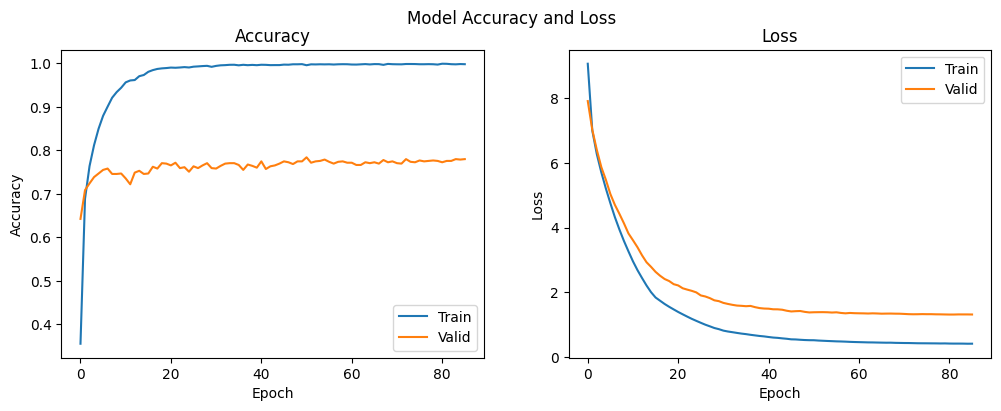

In [12]:
def plot_model(history):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
    fig.suptitle('Model Accuracy and Loss')

    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.title.set_text('Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train','Valid'],loc=4)

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.title.set_text('Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train','Valid'],loc=1)

    fig.show()

plot_model(history)

In [13]:
os.mkdir('/kaggle/working/new_test')
os.mkdir('/kaggle/working/new_test/test')
test_images=os.listdir('../input/dog-breed-identification/test/')

for i in range(len(test_images)):
    shutil.copy('../input/dog-breed-identification/test/'+test_images[i],'/kaggle/working/new_test/test')

In [14]:
test_generator = valid_datagen.flow_from_directory(
    '/kaggle/working/new_test/',
    target_size=(224,224),
    color_mode="rgb",
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 10357 images belonging to 1 classes.


In [17]:
test_generator.reset()
pred=model2.predict_generator(test_generator,verbose=1,steps=10357/32)

/tmp/ipykernel_34/1402990535.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=model2.predict_generator(test_generator,verbose=1,steps=10357/32)


323/323 [==============================] - 27s 82ms/step


In [18]:
n = len(labels)
n_class = len(breeds)  
class_to_num = dict(zip(breeds, range(n_class)))
num_to_class = dict(zip(range(n_class), breeds))

df2 = pd.read_csv('../input/dog-breed-identification/sample_submission.csv')

for b in breeds:
    df2[b] = pred[:,class_to_num[b]]

df2.to_csv('pred.csv', index=None)

In [19]:
predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [23]:
import os
from cv2 import imread
from keras.applications.inception_v3 import preprocess_input
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def predict(url, filename):
    # download and save
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((image_size, image_size))
    img.save(filename)
    
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    
    # predict
    img = imread(filename)
    img = preprocess_input(img)
    probs = model2.predict(np.expand_dims(img, axis=0))
    
    dict1 = {}
    for i, j in enumerate(probs[0]):
        dict1[i] = j
    
    # Find the index with the maximum probability
    max_index = max(dict1.keys(), key=(lambda k: dict1[k]))
    
    # Get the predicted breed and certainty percentage
    predicted_breed = breeds[max_index]
    certainty_percentage = (1 - dict1[max_index]) * 100.0
    
    print(f"Predicted Breed: {predicted_breed}")
    print(f"Certainty Percentage: {certainty_percentage:.2f}%")
    
    return predicted_breed, certainty_percentage


1/1 [==============================] - 0s 30ms/step
Predicted Breed: schipperke
Certainty Percentage: 96.21%


('schipperke', 96.2061058729887)

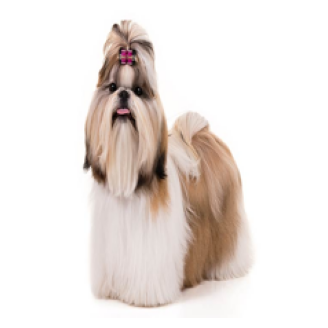

In [24]:
predict("https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12224329/Shih-Tzu-On-White-01.jpg",
                     "test_image_1.jpg")

1/1 [==============================] - 0s 30ms/step
Predicted Breed: irish_wolfhound
Certainty Percentage: 96.06%


('irish_wolfhound', 96.06018289923668)

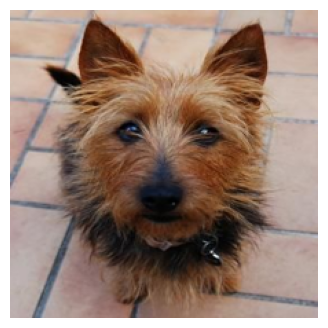

In [25]:
predict("https://i.pinimg.com/originals/18/59/c2/1859c289470c3fddd8be3d07bf8982b6.jpg",
                     "test_image_1.jpg")